In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from dataloader import engine # db connection

%matplotlib inline

## Artist Followers and Twitter Metrics

In [2]:
# load the twitter and artists social data tables into pandas
with engine.connect() as conn:
    # filter-join artist_socials and twitter tables
    query = f"""
            select *
            from (
                select username, follower_count
                from (SELECT *,
                        row_number() OVER (PARTITION BY artist_id
                                           ORDER BY follower_count DESC) rn
                    FROM song_pop.artist_socials) as innerQ
                where rn = 1
                    and username is not NULL) as lhs
            join
                (select username, followers, following, likes, tweets
                from (select *,
                        row_number() OVER (PARTITION BY id
                                           ORDER BY followers DESC) rn
                      from song_pop.twitter) as innerQ
                where rn = 1
                    and username is not NULL
                    and followers is not NULL
                    and following is not NULL
                    and likes is not NULL
                    and tweets is not NULL) as rhs
            using(username);
            """
    combined = pd.read_sql(query, conn)

In [3]:
combined.head()

,username,follower_count,followers,following,likes,tweets
0,bothofus_duo,14364,32,33,30,88
1,tailsxbeats,7789,3898,1046,20089,5549
2,fabianluttenb,1578,227,377,641,596
3,mwc_music,9489,1955,250,1968,2670
4,jimmoray,2607,6997,704,2449,10883


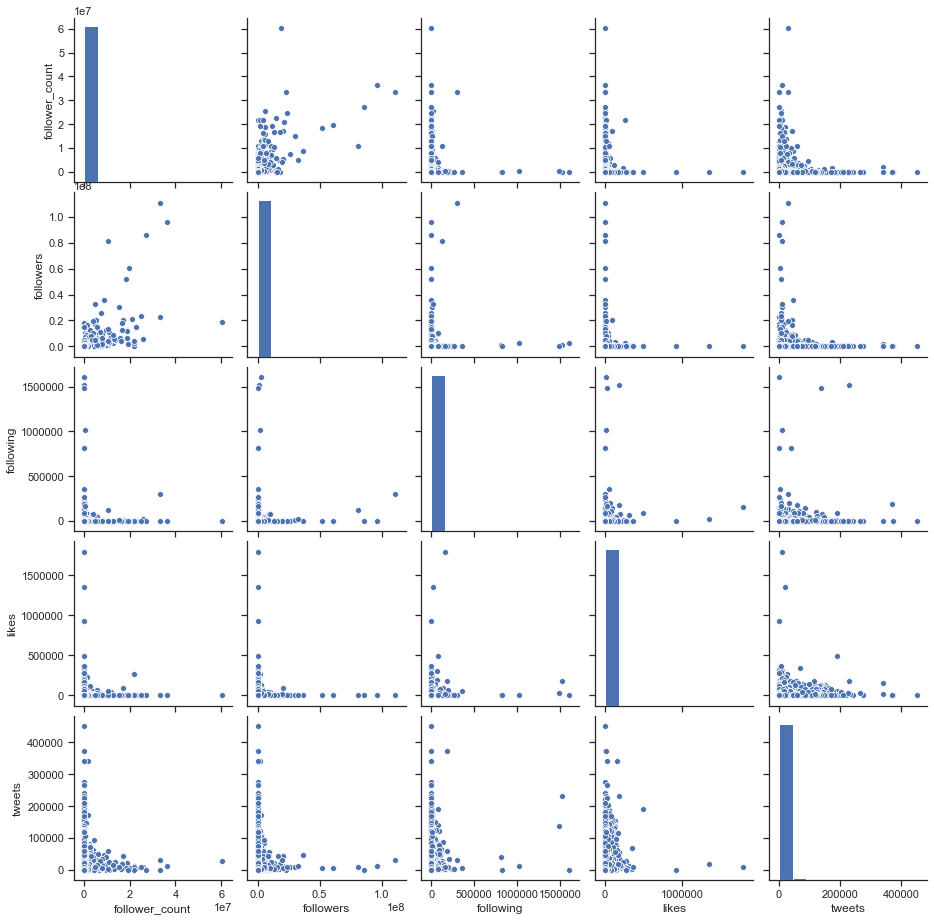

In [12]:
# plot every column except username (handled automatically by seaborn)
sns.set(style="ticks")
scatterMatrix = sns.pairplot(combined) 
plt.savefig('plot/follower_count_twitter_metrics_scatterMatrix.png')

## Artist Followers and Average Audio Metrics

In [13]:
# load tables into pandas
with engine.connect() as conn:
    # filter-join artist_socials and tracks tables
    query = f"""
            select
                follower_count, danceability, energy, loudness,
                speechiness, acousticness, instrumentalness, liveness,
                valence, tempo, time_signature, duration_ms
            from (
                select artist_id, avg(danceability) danceability,
                    avg(energy) energy, avg(loudness) loudness,
                    avg(speechiness) speechiness, avg(acousticness) acousticness,
                    avg(instrumentalness) instrumentalness, avg(liveness) liveness,
                    avg(valence) valence, avg(tempo) tempo,
                    avg(time_signature) time_signature, avg(duration_ms) duration_ms
                from song_pop.tracks
                group by artist_id) as lhs
            join
                (select artist_id, max(follower_count) follower_count
                from song_pop.artist_socials
                group by artist_id) as rhs
            using(artist_id)
            """
    combined = pd.read_sql(query, conn)

In [14]:
combined.head()

,follower_count,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms
0,3688,0.4962,0.5404,-10.4142,0.03396,0.18200,0.000002,0.30996,0.45280,135.4622,4.0,300281.2
1,426,0.7216,0.4552,-11.9514,0.40320,0.25548,0.008904,0.22232,0.47320,119.1238,3.8,96190.0
2,6892,0.7450,0.8370,-4.0160,0.04500,0.09700,0.000007,0.13900,0.83200,140.0080,4.0,181936.0
3,115,0.7220,0.6000,-5.6150,0.07610,0.10200,0.001020,0.24900,0.39900,97.0510,4.0,173808.0
4,129963,0.7431,0.6866,-6.2288,0.05680,0.27204,0.033046,0.08586,0.61114,111.2838,3.9,266790.4


In [16]:
combined.shape

(54562, 12)

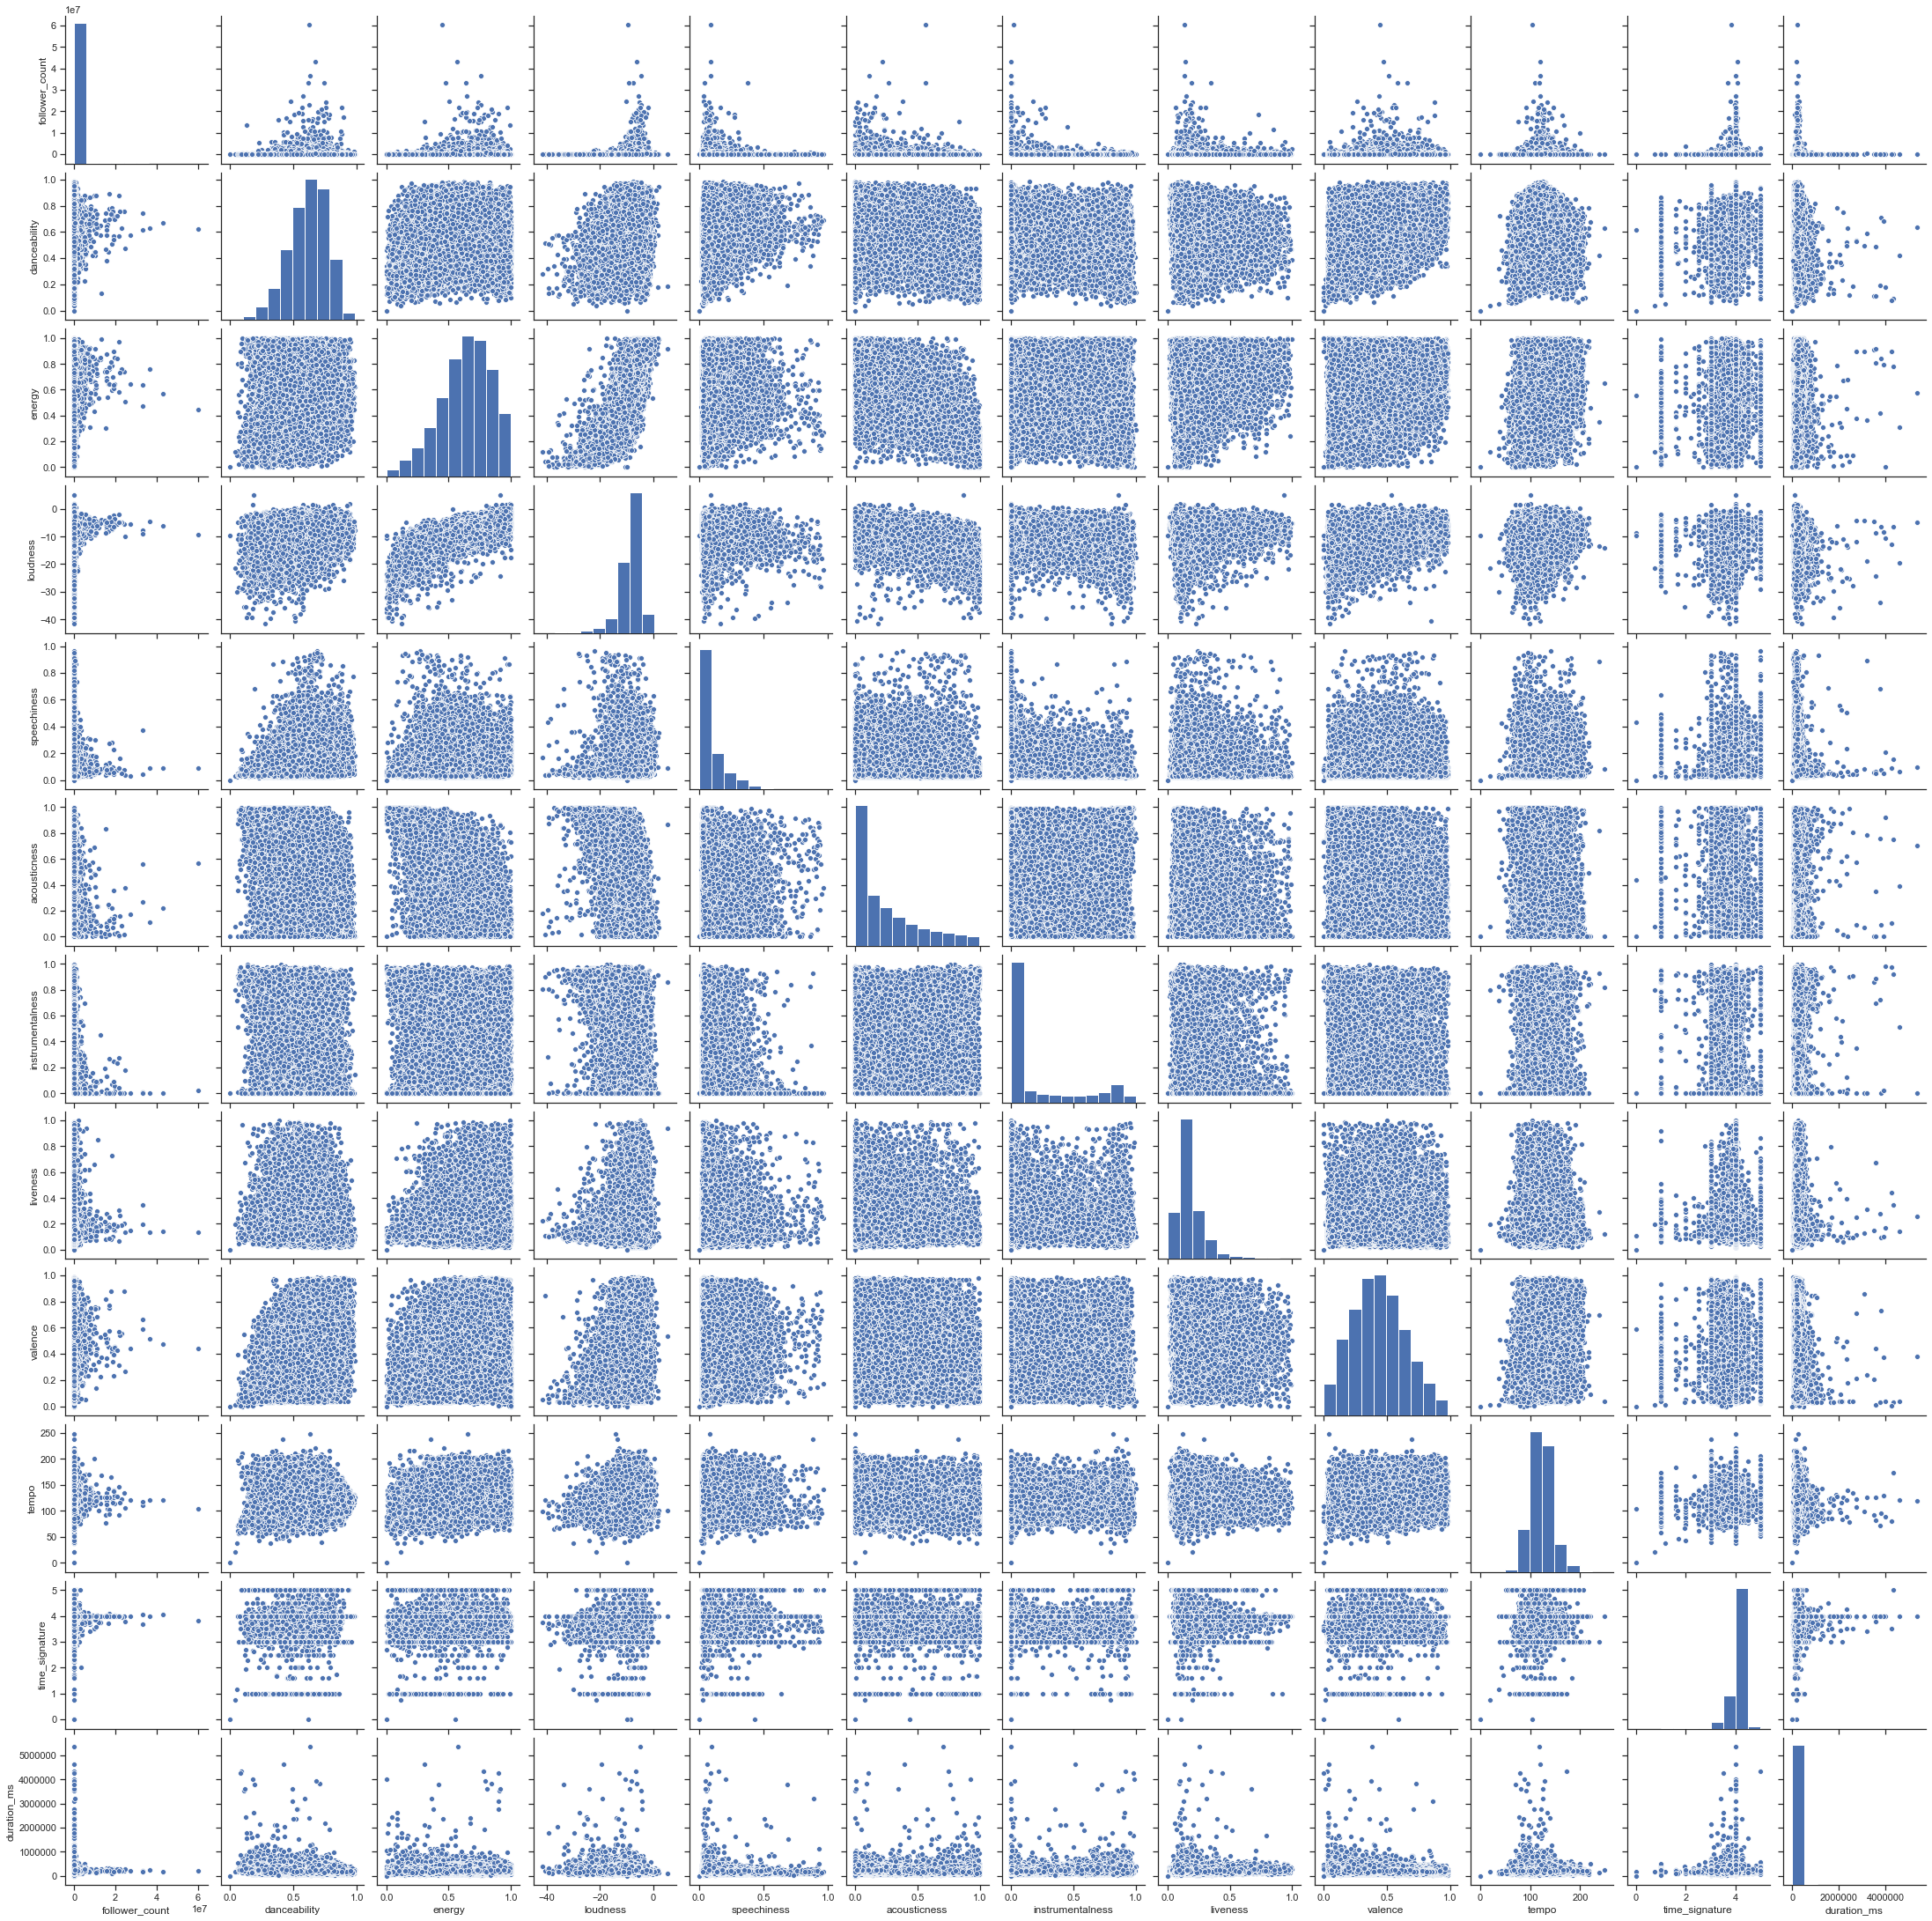

In [17]:
sns.set(style="ticks")
# plot every column except username (handled automatically by seaborn)
scatterMatrix = sns.pairplot(combined)

# save heatmap
plt.savefig('plot/follower_count_audio_characteristics_scatterMatrix.png')